**сеть Хемминга**

Евгений Борисов <esborisov@sevsu.ru>

Классификатор на основе нейронной сети Хемминга.   
http://mechanoid.su/neural-net-hamming-classifier.html

##  загружаем данные 

In [1]:
import pickle
import gzip

with gzip.open('data/30x30-123.pkl.gz','rb') as f: 
    ideal, test0,test1,test2,test3 = pickle.load(f)

In [2]:
import matplotlib.pyplot as plt

def plot_images(data,figsize=(10,4)):
    f, axarr = plt.subplots(1,len(data), sharey=False, sharex=False, figsize=figsize)
    for i in range(len(data)): 
        axarr[i].axis('off')
        axarr[i].imshow(data[i])

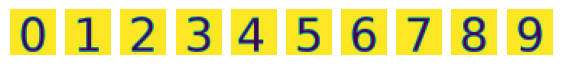

In [3]:
plot_images(ideal,(7,2))

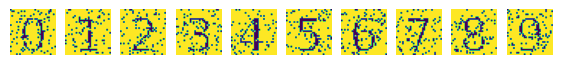

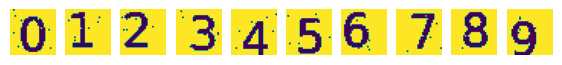

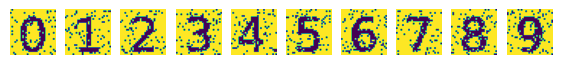

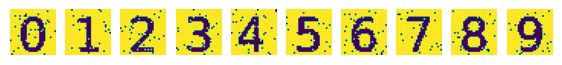

In [4]:
plot_images(test0,(7,2))
plot_images(test1,(7,2))
plot_images(test2,(7,2))
plot_images(test3,(7,2))

## формируем датасет

In [5]:
import numpy as np

In [6]:
(w,h),n = ideal[0].shape,len(ideal)
x_train = np.sign( 127.-np.stack(ideal).reshape(n,w*h) )

# (w,h),n = test[0].shape,len(test)
x_test0 = np.sign( 127.-np.stack(test0).reshape(n,w*h) )
x_test1 = np.sign( 127.-np.stack(test1).reshape(n,w*h) )
x_test2 = np.sign( 127.-np.stack(test2).reshape(n,w*h) )
x_test3 = np.sign( 127.-np.stack(test3).reshape(n,w*h) )

display( x_train.shape, x_test0.shape, x_test1.shape, x_test2.shape, x_test3.shape )

(10, 900)

(10, 900)

(10, 900)

(10, 900)

(10, 900)

In [7]:
# x_test0

# модель

![boltzman](http://mechanoid.su/content/neural-net-hamming-classifier.html/nnet.png)

In [8]:
class HammingNet:
    
    def __init__(self):
        self._weight_lin = 0.
        self._weight_hop = 0.
        
    def fit(self,x):
        self._weight_lin =  0.5*x.T
        
        n_samples,_ = x.shape # количество учебных примеров 
        c = 1./(2.*n_samples) # коэффициент торможения
        # веса для нейронов второго слоя
        self._weight_hop = -c*(np.ones(n_samples)-np.eye(n_samples)) + np.eye(n_samples)
        
        return self
    
    def forward(self,x,max_iter=6):
        o = x.dot(self._weight_lin)
        for n in range(max_iter):
            o_ = o.copy() # сохраняем состояние
            o = self._forward_step(o) # переходим в новое состояние
            # если состояние не изменилось то завершаем
            if np.all(o==o_): break
        return n,o        
    
    def _forward_step(self,x):
        return np.max( [x.dot(self._weight_hop), np.zeros(x.shape)],axis=0 )
    
    def __call__(self,x):
        return self.forward(x)
    
    def predict(self,x):
        n,o = self.forward(x)
        return n,np.argmax(o,axis=1)

# загружаем память сети

In [9]:
model = HammingNet().fit(x_train)

# тестируем

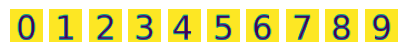

In [10]:
plot_images(ideal,(5,2))

5

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

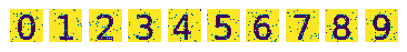

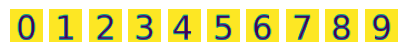

In [11]:
# мало зашумлённые
n,p = model.predict(x_test3)
display(n,p)
plot_images(test3,(5,2))
plot_images(np.stack(ideal)[p],(5,2))

5

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

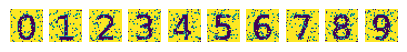

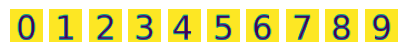

In [12]:
# средне зашумлённые
n,p = model.predict(x_test2)
display(n,p)
plot_images(test2,(5,2))
plot_images(np.stack(ideal)[p],(5,2))

5

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

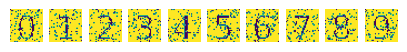

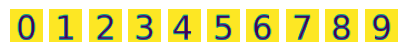

In [13]:
# сильно зашумлённые
n,p = model.predict(x_test0)
display(n,p)
plot_images(test0,(5,2))
plot_images(np.stack(ideal)[p],(5,2))

5

array([0, 7, 4, 3, 3, 5, 7, 7, 0, 4])

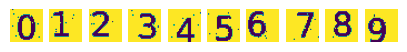

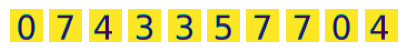

In [14]:
# искажение сдвигом
n,p = model.predict(x_test1)
display(n,p)
plot_images(test1,(5,2))
plot_images(np.stack(ideal)[p],(5,2))